In [1]:
import numpy as np
import pickle

import skimage.io as skio
import skimage.transform as skit
import skimage.measure as skim
import scipy.optimize as scpo

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
new_style = {'grid': False}
plt.rc('axes', **new_style)

import pulse2percept as p2p

2017-04-01 23:26:05,400 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
class InterpSim(p2p.Simulation):
    def __init__(self, implant, name=None, engine='joblib', dojit=True, num_jobs=-1):
        if not isinstance(implant, p2p.implants.ElectrodeArray):
            e_s = "`implant` must be of type p2p.implants.ElectrodeArray"
            raise TypeError(e_s)

        self.name = name
        self.implant = implant
        self.engine = engine
        self.dojit = dojit
        self.num_jobs = num_jobs

        # Optic fiber layer (OFL): After calling `set_optic_fiber_layer`, this
        # variable will contain a `p2p.retina.Grid` object.
        self.ofl = None

        # Ganglion cell layer (GCL): After calling `set_ganglion_cell_layer`,
        # this variable will contain a `p2p.retina.TemporalModel` object.
        self.gcl = None
        
    def set_ganglion_cell_layer(self, loadfile):
        from scipy.interpolate import RegularGridInterpolator
        import pickle
        
        in_list, out_list = pickle.load(open(loadfile, 'rb'))
        in_arr = np.array(in_list)
        amps = np.unique(in_arr[:, 0])
        freqs = np.unique(in_arr[:, 1])
        ecs = np.unique(in_arr[:, 2])
        out_arr = np.array(out_list).reshape((len(amps), len(freqs), len(ecs)))

        self.gcl = RegularGridInterpolator((amps, freqs, ecs), out_arr,
                                           bounds_error=False, fill_value=None)
        
    def pulse2percept(self, amps, freq, layers=['OFL', 'GCL']):
        if 'OFL' in layers:
            ecs, _ = self.ofl.electrode_ecs(self.implant)
        else:
            _, ecs = self.ofl.electrode_ecs(self.implant)
            
        # Sum up current contributions from all electrodes
        ecs = np.sum(ecs[:, :, 1, :] * amps.flatten(), axis=-1)
        
        out_list = np.array([self.gcl([a, freq, 1]) for a in ecs.flatten()])
        out_list[ecs.flatten() < 0] = 0.0
        return out_list.reshape(ecs.shape)

In [3]:
def calc_ssim(target, pred):
    return skim.compare_ssim(target / target.max(),
                             pred / pred.max(),
                             data_range=1.0,
                             gaussian_weights=True, sigma=1.5,
                             use_sample_covariance=False)

In [4]:
def calc_error(target, pred, amps, mode='ssim', lmb=0.0001):
    # reconstruction error
    if mode.lower() == 'ssim':
        reconst = (1.0 - calc_ssim(target, pred)) / 2.0
    elif mode.lower() == 'rmse':
        reconst = skim.compare_nrmse(target / target.max(), pred / pred.max())
    else:
        raise NotImplementedError

    # regularization
    regular = np.linalg.norm(amps.flatten())
    
    return reconst + lmb * regular

In [5]:
def plot_results(img_in, img_out, img_target, lmb=0.0001):
    ssim = calc_ssim(img_target, img_out)
    err = calc_error(img_target, img_out, img_in, mode='rmse', lmb=lmb)
    plt.subplot(131)
    plt.imshow(img_in.reshape((6, 10)), cmap='gray')
    plt.title('in')
    plt.subplot(132)
    plt.imshow(img_out, cmap='gray')
    plt.title('ssim=%.3f err=%.3f' % (ssim, err))
    plt.subplot(133)
    plt.imshow(img_target, cmap='gray')
    plt.title('target')

In [6]:
implant = p2p.implants.ArgusII()

In [8]:
# The approximated model, interpolated from an input-output function
sim = InterpSim(implant)
sim.set_optic_fiber_layer(sampling=200)
sim.set_ganglion_cell_layer('temporal-model-amps-freqs-ecs.dat')
sim.gcl.grid

(array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
          45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
          90.,   95.,  100.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5]))

In [9]:
letterfile = 'letters/G.jpg'

In [10]:
img = 255 - skio.imread(letterfile)
img.shape, img.min(), img.max()

((200, 256), 0, 255)

In [11]:
img = img[50:150, 70:190]
img_small = skit.resize(img, (6, 10))
img_small.shape, img_small.min(), img_small.max()

((6, 10), 0.0, 1.0)

In [12]:
target = skit.resize(img, (21, 31))
target.shape, target.min(), target.max()

((21, 31), 0.0, 1.0)

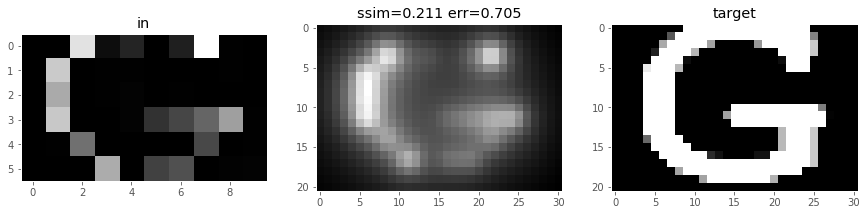

In [19]:
xopt = pickle.load(open('../../scripts/xopt-rmse-G-GCL.dat', 'rb'))
xopt = np.maximum(0, xopt)
layers = ['GCL']
out = sim.pulse2percept(xopt, 20, layers=layers)
plt.figure(figsize=(15, 6))
plot_results(xopt, out, target)

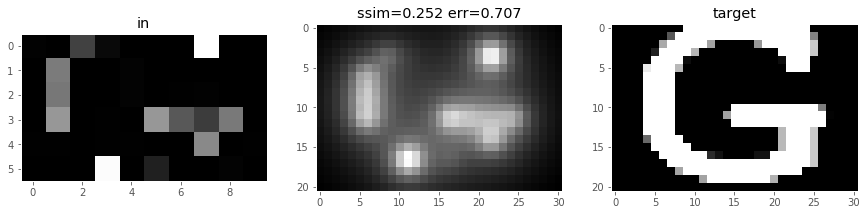

In [20]:
xopt = pickle.load(open('../../scripts/xopt-ssim-G-GCL.dat', 'rb'))
xopt = np.maximum(0, xopt)
layers = ['GCL']
out = sim.pulse2percept(xopt, 20, layers=layers)
plt.figure(figsize=(15, 6))
plot_results(xopt, out, target)

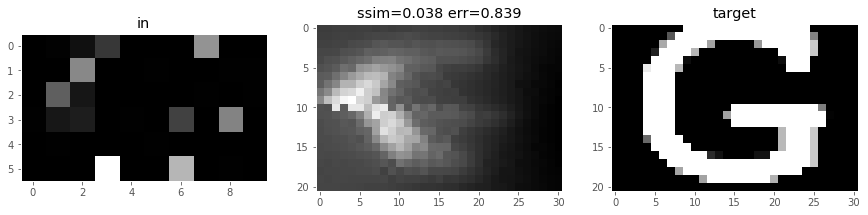

In [21]:
xopt = pickle.load(open('../../scripts/xopt-rmse-G-OFL.dat', 'rb'))
xopt = np.maximum(0, xopt)
layers = ['GCL', 'OFL']
out = sim.pulse2percept(xopt, 20, layers=layers)
plt.figure(figsize=(15, 6))
plot_results(xopt, out, target)

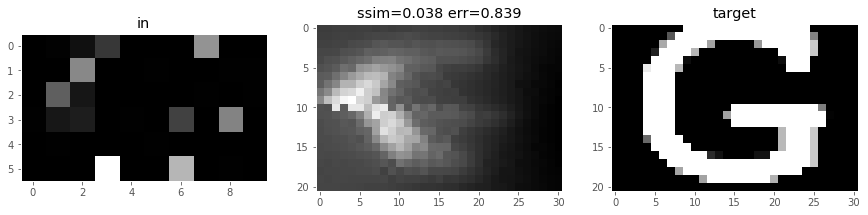

In [22]:
xopt = pickle.load(open('../../scripts/xopt-ssim-G-OFL.dat', 'rb'))
xopt = np.maximum(0, xopt)
layers = ['GCL', 'OFL']
out = sim.pulse2percept(xopt, 20, layers=layers)
plt.figure(figsize=(15, 6))
plot_results(xopt, out, target)